# 1. Standard Scaler formatting of the new features: sigma & volume

In [ ]:
import uproot as ur
import awkward as ak
import numpy as np

In [ ]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

from energyflow.utils import data_split

In [ ]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'


data_path = '/fast_scratch/atlas_images/v01-45/'

In [ ]:
# import graph utilities
import sys
sys.path.append(path_prefix)
from  util import graph_util as gu
from  util import plot_util as pu

In [ ]:
#X = np.load(data_path+'X_4.npy')
X = np.load(path_prefix+'X_added.npy')

In [ ]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))

In [27]:
X[0,0]

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        2.73519077e+01,  6.52059000e+05])

# scaling

class sklearn.preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)   [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

Use the training sample for getting the mean and the standard deviation

In [39]:
X_train[0,0]

array([-1.66614178e+00,  1.40906572e-02, -1.07079029e-01,  1.30000000e+00,
        2.26714191e+01,  7.70242400e+07])

In [145]:
print("Train sample: ", len(X_train))
print("Validation sample: ", len(X_val))
print("Test sample: ", len(X_test))

Train sample:  130000
Validation sample:  10000
Test sample:  40000


# sigma

In [40]:
#Sigma
X_train[:,:,4]

array([[22.67141914, 22.99622536, 24.52235603, ...,  0.        ,
         0.        ,  0.        ],
       [27.89340019, 27.89340019, 27.89340019, ...,  0.        ,
         0.        ,  0.        ],
       [28.03528786, 28.03528786, 28.03528786, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [37.78477859, 11.0093174 , 10.97433281, ...,  0.        ,
         0.        ,  0.        ],
       [29.11943054, 29.11943054, 29.11943054, ...,  0.        ,
         0.        ,  0.        ],
       [11.22116661, 11.22116661, 11.22116661, ...,  0.        ,
         0.        ,  0.        ]])

Calculate the mean and the RMS for the non-zero entries

In [41]:
X_train_sigma_flat=ak.flatten(X_train[:,:,4])

In [42]:
X_train_sigma_flat

<Array [22.7, 23, 24.5, 21.6, ... 0, 0, 0, 0] type='260000000 * float64'>

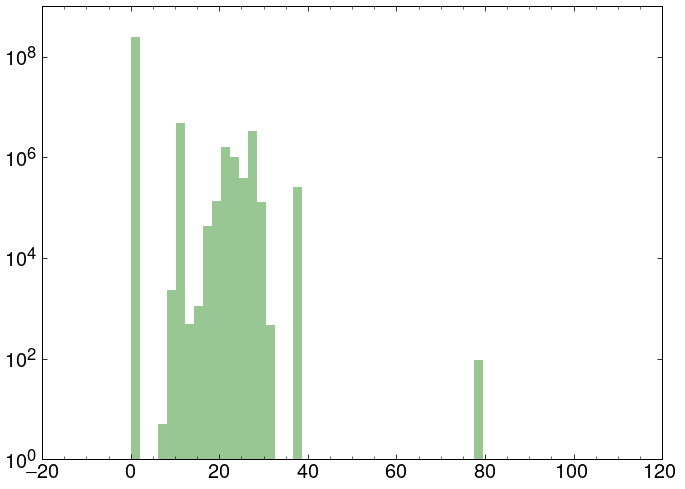

In [62]:
fig = plt.figure()
plt.hist(X_train_sigma_flat, bins=np.linspace(0.0,100.,50,endpoint=True))
plt.yscale('log')
plt.show()

In [45]:
NonZeroMask = np.invert(X_train_sigma_flat==0)

In [49]:
len(X_train_sigma_flat)

260000000

In [50]:
X_train_sigma_flat_nozero = X_train_sigma_flat[NonZeroMask]

In [53]:
X_train_sigma_flat_nozero

<Array [22.7, 23, 24.5, ... 11.1, 11.3, 11.3] type='11699234 * float64'>

In [57]:
print("Number of zero padded cells:", len(X_train_sigma_flat) - len(X_train_sigma_flat_nozero))
print("Number of effective cells:", len(X_train_sigma_flat_nozero))
print("Percentage of effective cells:", (len(X_train_sigma_flat_nozero)*100.)/ len(X_train_sigma_flat))

Number of zero padded cells: 248300766
Number of effective cells: 11699234
Percentage of effective cells: 4.4997053846153845


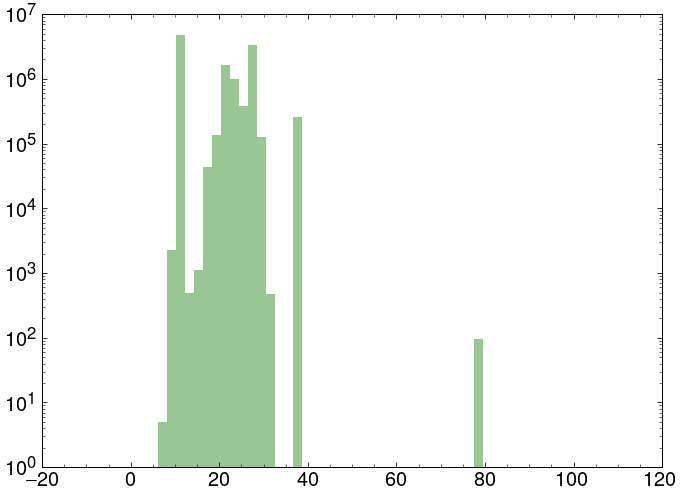

In [132]:
fig = plt.figure()
plt.hist(X_train_sigma_flat_nozero, bins=np.linspace(0.0,100.,50,endpoint=True))
plt.yscale('log')
plt.show()

In [66]:
Sum_sigma = np.sum(X_train_sigma_flat_nozero)

In [74]:
#SUM OF ALL THE VALUES OF SIGMA
Sum_sigma

230644343.17050552

In [82]:
mean_sigma = np.mean(X_train_sigma_flat_nozero)

In [83]:
print("Mean by hand: ", Sum_sigma/len(X_train_sigma_flat_nozero))
print("Mean from numpy:" , np.mean(X_train_sigma_flat_nozero))
print("Median from numpy:" , np.ma.median(X_train_sigma_flat_nozero))  # he median is the middle value of a sorted copy of V

Calculated mean:  19.714482432824706
Mean from numpy: 19.714482432824706
Median from numpy: 21.60210418701172


In [135]:
std_sigma=np.std(X_train_sigma_flat_nozero)

In [89]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(X_train_sigma_flat_nozero,[0 for _ in X_train_sigma_flat_nozero], squared=False)
print("Std from numpy:" , np.std(X_train_sigma_flat_nozero))
print("RMS by hand:" , np.sqrt(np.mean(X_train_sigma_flat_nozero**2)))
print("RMS from sklearn:" , rmse)
print("Variance: ", np.var(X_train_sigma_flat_nozero,ddof=0))  #std squared

Std from numpy: 7.736588045868299
RMS by hand: 21.17818717892602
RMS from sklearn: 21.17818717892602
Variance:  59.854794591472256


## scale with mean and std pof sigma the complete input X

In [113]:
X[0,282] #start to be padded with zero

array([0., 0., 0., 0., 0., 0.])

In [114]:
X[0,0] 

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        2.73519077e+01,  6.52059000e+05])

In [107]:
X_scaled = X

In [111]:
X_scaled[0,282]

array([0., 0., 0., 0., 0., 0.])

numpy.where(condition[, x, y])


condition : Where True, yield x, otherwise yield y.

In [115]:
mean_sigma

19.714482432824706

In [137]:
std_sigma

7.736588045868299

In [122]:
from tqdm import tqdm

In [124]:
X_scaled[:,:,4] = np.where( X[:,:,4] != 0. ,  ( X[:,:,4] - mean_sigma)/ std_sigma , X[:,:,4]    )

In [125]:
X_scaled[0,282]

array([0., 0., 0., 0., 0., 0.])

In [129]:
X_scaled[0,0] 

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        9.87182625e-01,  6.52059000e+05])

In [128]:
X_scaled.shape

(180000, 2000, 6)

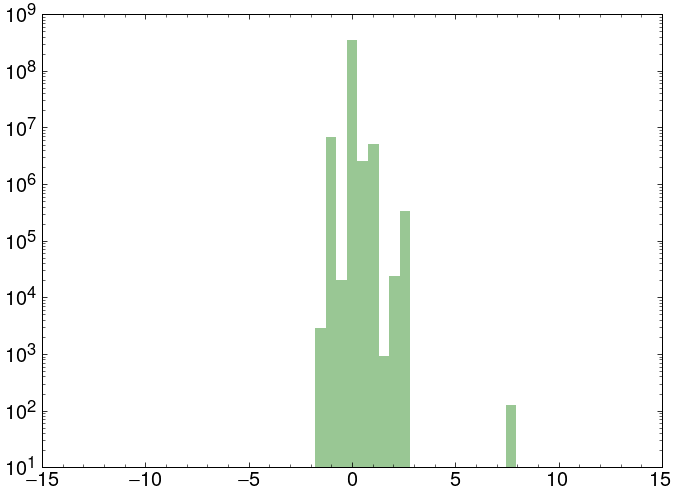

In [140]:
fig = plt.figure()
plt.hist(ak.flatten(X_scaled[:,:,4]), bins=np.linspace(-10,10,40,endpoint=True))
plt.yscale('log')
plt.show()

# Volume

In [141]:
#Volume
X_train[:,:,5]

array([[77024240. , 77024240. , 77024240. , ...,        0. ,        0. ,
               0. ],
       [  724224. ,   724224. ,   724224. , ...,        0. ,        0. ,
               0. ],
       [  680446. ,   680446. ,   680446. , ...,        0. ,        0. ,
               0. ],
       ...,
       [       0. ,   101338. ,   101473. , ...,        0. ,        0. ,
               0. ],
       [  707737. ,   707737. ,   707737. , ...,        0. ,        0. ,
               0. ],
       [   99135.5,    99135.5,    99135.5, ...,        0. ,        0. ,
               0. ]])

Calculate the mean and the RMS for the non-zero entries

In [142]:
X_train_volume_flat=ak.flatten(X_train[:,:,5])

In [143]:
X_train_volume_flat

<Array [7.7e+07, 7.7e+07, 7.7e+07, ... 0, 0, 0] type='260000000 * float64'>

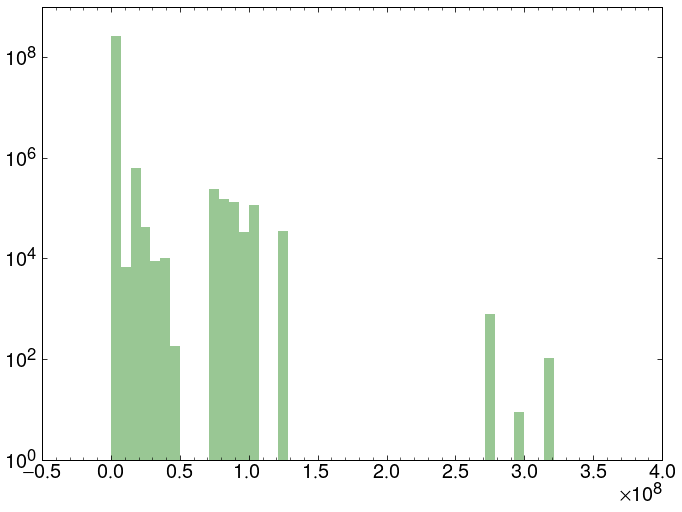

In [148]:
fig = plt.figure()
plt.hist( X_train_volume_flat, bins=np.linspace(0.0,3.5e8,50,endpoint=True))
plt.yscale('log')
plt.show()

Take out zero padded entries

In [149]:
NonZeroMask_vol = np.invert(X_train_volume_flat==0)

In [150]:
len(X_train_volume_flat)

260000000

In [151]:
X_train_volume_flat_nozero = X_train_volume_flat[NonZeroMask_vol]

In [154]:
X_train_volume_flat_nozero

<Array [7.7e+07, 7.7e+07, ... 9.9e+04, 9.9e+04] type='11441136 * float64'>

In [155]:
print("Number of zero padded cells:", len(X_train_volume_flat) - len(X_train_volume_flat_nozero))
print("Number of effective cells:", len(X_train_volume_flat_nozero))
print("Percentage of effective cells:", (len(X_train_volume_flat_nozero)*100.)/ len(X_train_volume_flat))

Number of zero padded cells: 248558864
Number of effective cells: 11441136
Percentage of effective cells: 4.400436923076923


????????? Why this values are different for volume entry wrt sigma entry

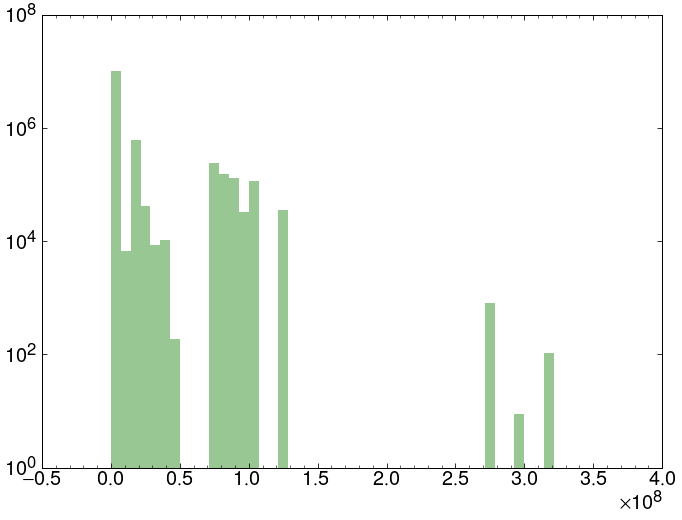

In [156]:
fig = plt.figure()
plt.hist(X_train_volume_flat_nozero, bins=np.linspace(0.0,3.5e8,50,endpoint=True))
plt.yscale('log')
plt.show()

In [157]:
Sum_volume = np.sum(X_train_volume_flat_nozero)

In [158]:
#SUM OF ALL THE VALUES OF SIGMA
Sum_volume

79580778724926.23

In [159]:
mean_volume = np.mean(X_train_volume_flat_nozero)

In [160]:
mean_volume

6955671.073652672

In [161]:
print("Mean by hand: ", Sum_volume/len(X_train_volume_flat_nozero))
print("Mean from numpy:" , np.mean(X_train_volume_flat_nozero))
print("Median from numpy:" , np.ma.median(X_train_volume_flat_nozero))  # he median is the middle value of a sorted copy of V

Mean by hand:  6955671.073652672
Mean from numpy: 6955671.073652672
Median from numpy: 368405.0


In [162]:
std_volume=np.std(X_train_volume_flat_nozero)

In [163]:
std_volume

21670291.344921328

In [164]:
rmse_volume = mean_squared_error(X_train_volume_flat_nozero,[0 for _ in X_train_volume_flat_nozero], squared=False)
print("Std from numpy:" , np.std(X_train_volume_flat_nozero))
print("RMS by hand:" , np.sqrt(np.mean(X_train_volume_flat_nozero**2)))
print("RMS from sklearn:" , rmse_volume)
print("Variance: ", np.var(X_train_volume_flat_nozero,ddof=0))  #std squared

Std from numpy: 21670291.344921328
RMS by hand: 22759237.40063848
RMS from sklearn: 22759237.40063848
Variance:  469601526973772.25


## scale with mean and std of volume the complete input X

In [165]:
X[0,282] #start to be padded with zero

array([0., 0., 0., 0., 0., 0.])

In [166]:
X[0,0] 

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        9.87182625e-01,  6.52059000e+05])

numpy.where(condition[, x, y])


condition : Where True, yield x, otherwise yield y.

In [168]:
mean_volume

6955671.073652672

In [169]:
std_volume

21670291.344921328

In [170]:
X_scaled[:,:,5] = np.where( X[:,:,5] != 0. ,  ( X[:,:,5] - mean_volume )/ std_volume , X[:,:,5]    )

In [171]:
X_scaled[0,282]

array([0., 0., 0., 0., 0., 0.])

In [173]:
X_scaled[0,0] 

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        9.87182625e-01, -2.90887279e-01])

In [129]:
X_scaled[0,0] #Previous

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        9.87182625e-01,  6.52059000e+05])

In [174]:
X_scaled.shape

(180000, 2000, 6)

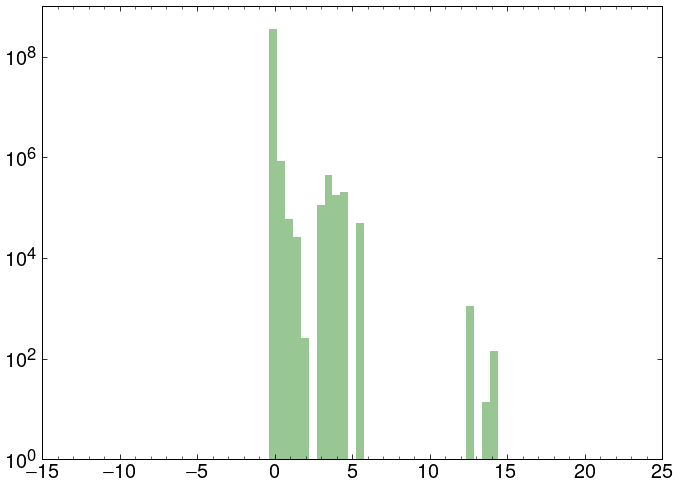

In [182]:
fig = plt.figure()
plt.hist(ak.flatten(X_scaled[:,:,5]), bins=np.linspace(-10,20,60,endpoint=True))
plt.yscale('log')
plt.show()

In [184]:
np.save(path_prefix+'X_added_standarscaled.npy', X)

# 1. PFN fwith the new scaled features: sigma & volume

## Phi_sizes, F_sizes and latent space dimensions

* Phi_sizes : The sizes of the dense layers in the per-particle frontend module $\Phi$. The last element will be the number of latent observables that the model defines. Larger latent space dimensions correspond roughly to higher resolution images.
* F_sizes : The sizes of the dense layers in the backend module $F$.

Default: Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100) 

In [186]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X_scaled, Y, val=10000, test=40000)

In [187]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

## Features in training sample

In [191]:
len(X_train)

130000

In [192]:
len(X_scaled)

180000

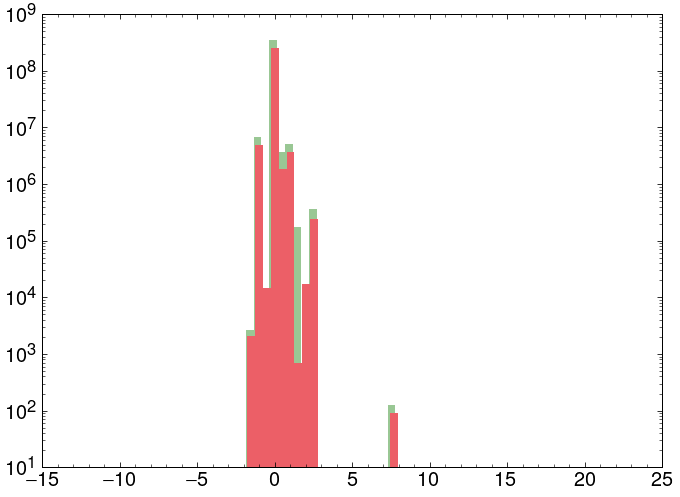

In [198]:
fig = plt.figure()
plt.hist(ak.flatten(X_scaled[:,:,4]), bins=np.linspace(-10,20,60,endpoint=True))
plt.hist(ak.flatten(X_train[:,:,4]), bins=np.linspace(-10,10,40,endpoint=True))
plt.yscale('log')
plt.show()

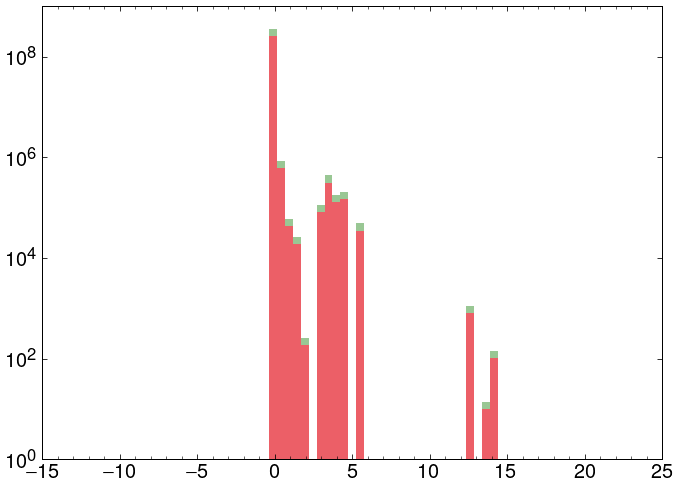

In [195]:
fig = plt.figure()
plt.hist(ak.flatten(X_scaled[:,:,5]), bins=np.linspace(-10,20,60,endpoint=True))
plt.hist(ak.flatten(X_train[:,:,5]), bins=np.linspace(-10,20,60,endpoint=True))
plt.yscale('log')
plt.show()

## PFN with dimension 6 inputs: (log(E),eta,phi,samplerID, cellSignificance, cellVolume)

In [199]:
pfn_6dim = PFN(input_dim=X_scaled.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 6)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    700         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [201]:
# train model
history_6dim = pfn_6dim.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 20s 60ms/step - loss: 9.6695 - acc: 0.7152 - val_loss: 0.3628 - val_acc: 0.8349
Epoch 2/100
260/260 [==============================] - 15s 59ms/step - loss: 0.4486 - acc: 0.8489 - val_loss: 0.3109 - val_acc: 0.8900
Epoch 3/100
260/260 [==============================] - 16s 62ms/step - loss: 0.4102 - acc: 0.8628 - val_loss: 0.2990 - val_acc: 0.8922
Epoch 4/100
260/260 [==============================] - 15s 57ms/step - loss: 0.2907 - acc: 0.8946 - val_loss: 0.2833 - val_acc: 0.8973
Epoch 5/100
260/260 [==============================] - 15s 57ms/step - loss: 0.2868 - acc: 0.8969 - val_loss: 0.2975 - val_acc: 0.8944
Epoch 6/100
260/260 [==============================] - 15s 59ms/step - loss: 0.2881 - acc: 0.8952 - val_loss: 0.2761 - val_acc: 0.8997
Epoch 7/100
260/260 [==============================] - 15s 57ms/step - loss: 0.2658 - acc: 0.9026 - val_loss: 0.2600 - val_acc: 0.9042
Epoch 8/100
260/260 [==============================] - 

In [202]:
pfn_6dim.save(modelpath+'pfn_StandardScaled_6dim.h5')

In [203]:
# get area under the ROC curve
preds_6dim = pfn_6dim.predict(X_test, batch_size=1000)
auc_6dim = roc_auc_score(Y_test[:,1], preds_6dim[:,1])
print('AUC:', auc_6dim)

### get ROC curve
pfn_fp_6dim, pfn_tp_6dim, threshs_6dim = roc_curve(Y_test[:,1], preds_6dim[:,1])
Rej_6dim=1./pfn_fp_6dim
highEff=pfn_tp_6dim>0.95
pfn_tp_highEff_6dim = pfn_tp_6dim[highEff]
Rej_highEff_6dim=Rej_6dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_6dim,Rej_highEff_6dim))
print("Rejection at 95% efficiency:", Rej_highEff_6dim[0])

print("at efficiency:", pfn_tp_highEff_6dim[0])
print("AUC:",auc(pfn_tp_6dim,Rej_6dim))

AUC: 0.9782421511046163
High efficiency AUC: 0.2319710629408842
Rejection at 95% efficiency: 8.477079796264857
at efficiency: 0.9500199720391452
AUC: inf


<ipython-input-203-db4b63df363d>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_6dim=1./pfn_fp_6dim


<Figure size 799.992x599.976 with 0 Axes>

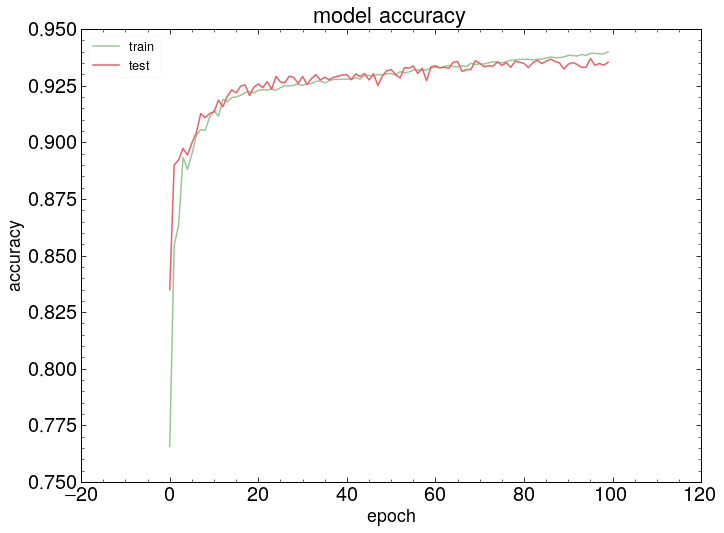

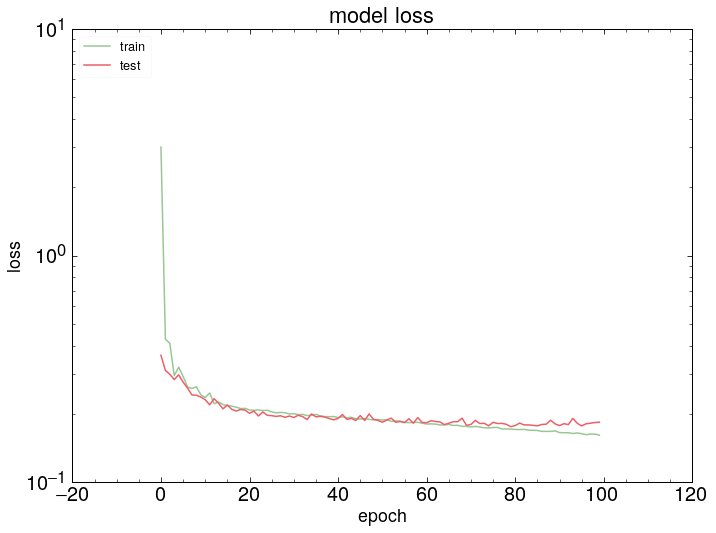

In [204]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_6dim.history['acc'])
plt.plot(history_6dim.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_6dim.history['loss'])
plt.plot(history_6dim.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<ipython-input-205-bfee9da9f13e>:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='red', label='PFN')


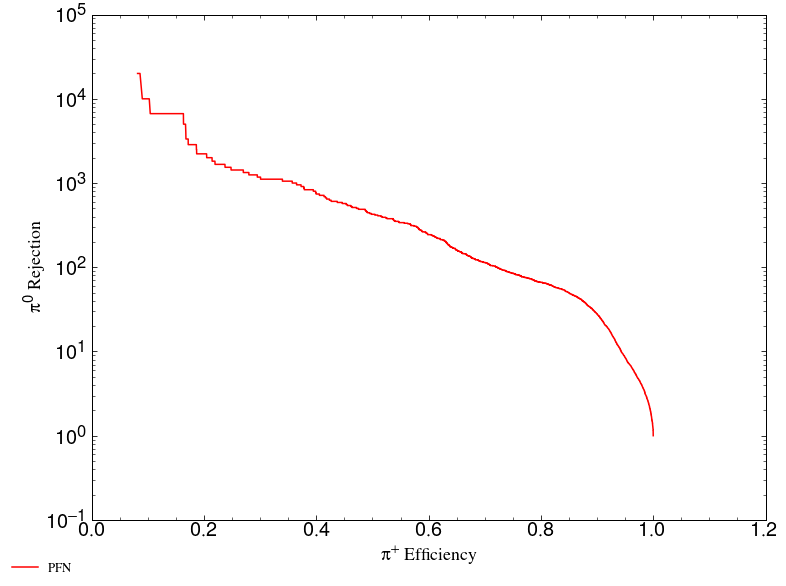

In [205]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

#fig, axes = plt.subplots(1, 1, figsize=(5,5))

fig = plt.figure()

plt.yscale('log')

# plot the ROC curves
plt.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='red', label='PFN')

plt.ylabel('$\pi^{0}$ Rejection')
plt.xlabel('$\pi^{+}$ Efficiency')


# axes limits
#axes.set_xlim(0.5, 1)
#axes.set_ylim(-1, 1000)

# make legend and show plot
fig.legend(loc='lower left', frameon=False)

plt.show()

## PFN with dimension 5 inputs: (log(E),eta,phi,samplerID, cellSignificance)

In [206]:
# ignore  cellVolume information 
X_5dim=X_scaled[:,:,:5]

In [207]:
X_5dim.shape[-1]

5

In [210]:
pfn_5dim = PFN(input_dim=X_5dim.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [212]:
# do train/val/test split 
(X_5dim_train, X_5dim_val, X_5dim_test,
 Y_train, Y_val, Y_test) = data_split(X_5dim, Y, val=10000, test=40000)

In [214]:
# train model
history_5dim = pfn_5dim.fit(X_5dim_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_5dim_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 24s 89ms/step - loss: 7.2263 - acc: 0.7230 - val_loss: 0.4669 - val_acc: 0.7822
Epoch 2/100
260/260 [==============================] - 14s 56ms/step - loss: 0.5233 - acc: 0.8128 - val_loss: 0.3918 - val_acc: 0.8178
Epoch 3/100
260/260 [==============================] - 14s 55ms/step - loss: 0.3395 - acc: 0.8755 - val_loss: 0.4634 - val_acc: 0.8425
Epoch 4/100
260/260 [==============================] - 15s 56ms/step - loss: 0.3514 - acc: 0.8749 - val_loss: 0.4779 - val_acc: 0.8649
Epoch 5/100
260/260 [==============================] - 14s 55ms/step - loss: 0.3700 - acc: 0.8724 - val_loss: 0.3005 - val_acc: 0.8823
Epoch 6/100
260/260 [==============================] - 15s 58ms/step - loss: 0.2812 - acc: 0.8960 - val_loss: 0.3166 - val_acc: 0.8876
Epoch 7/100
260/260 [==============================] - 14s 55ms/step - loss: 0.3323 - acc: 0.8834 - val_loss: 0.2864 - val_acc: 0.8852
Epoch 8/100
260/260 [==============================] - 

In [215]:
pfn_5dim.save(modelpath+'pfn_StandardScaled_5dim.h5')

In [216]:
# get area under the ROC curve
preds_5dim = pfn_5dim.predict(X_5dim_test, batch_size=1000)
auc_5dim = roc_auc_score(Y_test[:,1], preds_5dim[:,1])
print('AUC:', auc_5dim)

### get ROC curve
pfn_fp_5dim, pfn_tp_5dim, threshs_5dim = roc_curve(Y_test[:,1], preds_5dim[:,1])
Rej_5dim=1./pfn_fp_5dim
highEff=pfn_tp_5dim>0.95
pfn_tp_highEff_5dim = pfn_tp_5dim[highEff]
Rej_highEff_5dim=Rej_5dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_5dim,Rej_highEff_5dim))
print("Rejection at 95% efficiency:", Rej_highEff_5dim[0])

print("at efficiency:", pfn_tp_highEff_5dim[0])
print("AUC:",auc(pfn_tp_5dim,Rej_5dim))

AUC: 0.9783296587788871
High efficiency AUC: 0.22669833391573602
Rejection at 95% efficiency: 8.188957055214724
at efficiency: 0.95004504955451
AUC: inf


<ipython-input-216-90048c455d95>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_5dim=1./pfn_fp_5dim


<Figure size 799.992x599.976 with 0 Axes>

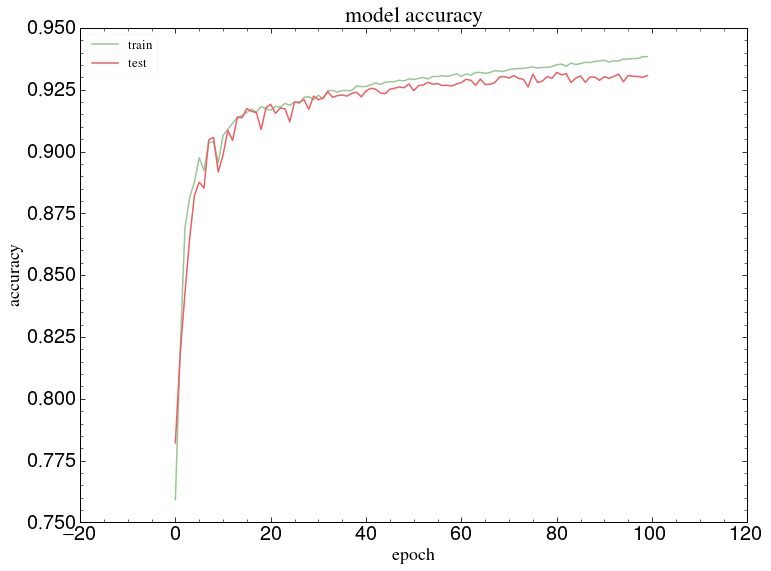

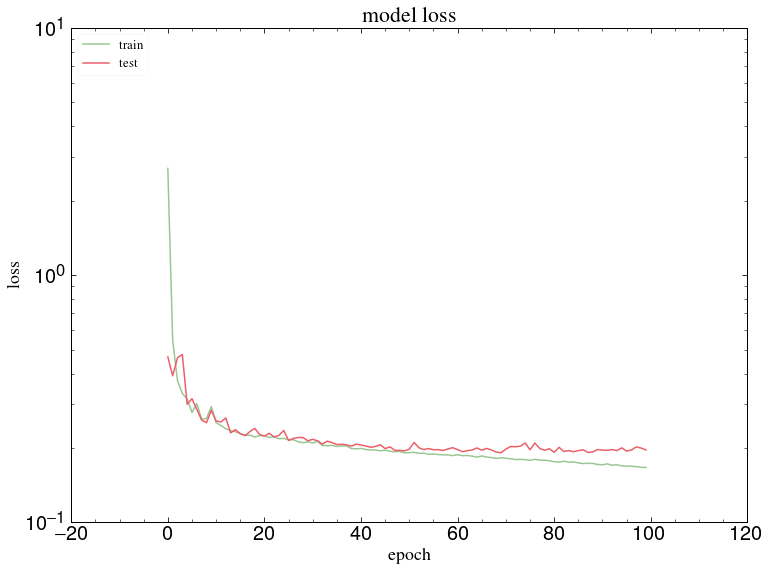

In [217]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_5dim.history['acc'])
plt.plot(history_5dim.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_5dim.history['loss'])
plt.plot(history_5dim.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<ipython-input-218-415cd752c546>:9: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='red', label='PFN')
<ipython-input-218-415cd752c546>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


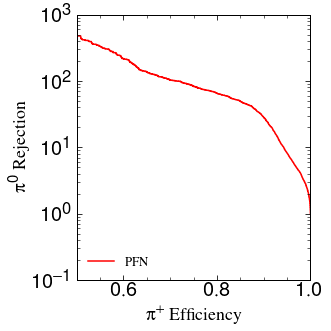

In [218]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='red', label='PFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## PFN with dimension 4 inputs: (log(E),eta,phi,samplerID)

In [219]:
# ignore cellSignificance, cellVolume information 
X_4D=X[:,:,:4]

In [220]:
X_4D.shape[-1]

4

In [221]:
# do train/val/test split 
(X_4D_train, X_4D_val, X_4D_test,
 Y_train, Y_val, Y_test) = data_split(X_4D, Y, val=10000, test=40000)

In [222]:
pfn_4dim=tf.keras.models.load_model(modelpath+'pfn_4dim.h5')

In [223]:
# get area under the ROC curve
preds_4dim = pfn_4dim.predict(X_4D_test, batch_size=1000)
auc_4dim = roc_auc_score(Y_test[:,1], preds_4dim[:,1])
print('AUC:', auc_4dim)

### get ROC curve
pfn_fp_4dim, pfn_tp_4dim, threshs_4dim = roc_curve(Y_test[:,1], preds_4dim[:,1])
Rej_4dim=1./pfn_fp_4dim
highEff=pfn_tp_4dim>0.95
pfn_tp_highEff_4dim = pfn_tp_4dim[highEff]
Rej_highEff_4dim=Rej_4dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_4dim,Rej_highEff_4dim))
print("Rejection at 95% efficiency:", Rej_highEff_4dim[0])

print("at efficiency:", pfn_tp_highEff_4dim[0])
print("AUC:",auc(pfn_tp_4dim,Rej_4dim))

AUC: 0.9805204617338513
High efficiency AUC: 0.25034157358102643
Rejection at 95% efficiency: 9.399528301886793
at efficiency: 0.9500323818064066
AUC: inf


<ipython-input-223-103b5ea18793>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_4dim=1./pfn_fp_4dim


## PFN with dimension 3 inputs: (log(E),eta,phi)

In [224]:
# ignore cellSignificance, cellVolume information 
X_3dim=X[:,:,:3]

In [225]:
X_3dim.shape[-1]

3

In [226]:
# do train/val/test split 
(X_3dim_train, X_3dim_val, X_3dim_test,
 Y_train, Y_val, Y_test) = data_split(X_3dim, Y, val=10000, test=40000)

In [227]:
pfn_3dim=tf.keras.models.load_model(modelpath+'pfn_3dim.h5')

In [228]:
# get area under the ROC curve
preds_3dim = pfn_3dim.predict(X_3dim_test, batch_size=1000)
auc_3dim = roc_auc_score(Y_test[:,1], preds_3dim[:,1])
print('AUC:', auc_3dim)

### get ROC curve
pfn_fp_3dim, pfn_tp_3dim, threshs_3dim = roc_curve(Y_test[:,1], preds_3dim[:,1])
Rej_3dim=1./pfn_fp_3dim
highEff=pfn_tp_3dim>0.95
pfn_tp_highEff_3dim = pfn_tp_3dim[highEff]
Rej_highEff_3dim=Rej_3dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_3dim,Rej_highEff_3dim))
print("Rejection at 95% efficiency:", Rej_highEff_3dim[0])

print("at efficiency:", pfn_tp_highEff_3dim[0])
print("AUC:",auc(pfn_tp_3dim,Rej_3dim))


AUC: 0.9732648287145402
High efficiency AUC: 0.19020256192465887
Rejection at 95% efficiency: 6.301928548846033
at efficiency: 0.9500672746299895
AUC: inf


<ipython-input-228-fb24a46c3d86>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_3dim=1./pfn_fp_3dim


<ipython-input-229-3d7132f8717f>:9: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='PFN')
<ipython-input-229-3d7132f8717f>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


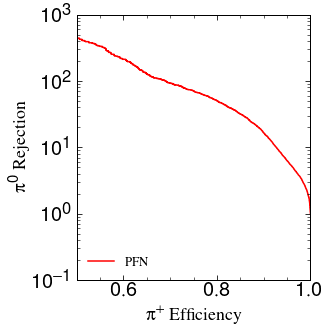

In [229]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='PFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## Sumary of the performance

<ipython-input-230-fb9e6022fed4>:12: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='3D')
<ipython-input-230-fb9e6022fed4>:13: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='blue', label='3D+samplerID')
<ipython-input-230-fb9e6022fed4>:14: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='black', label='3D+samplerID+Noise')
<ipython-input-230-fb9e6022fed4>:15: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='orange', label='3D+samplerID+Noise+Volume')
<ipython-input-230-fb9e6022fed4>:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


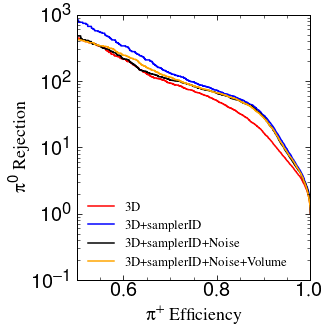

In [230]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

######################### ROC Curve Plot #########################

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='3D')
axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='blue', label='3D+samplerID')
axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='black', label='3D+samplerID+Noise')
axes.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='orange', label='3D+samplerID+Noise+Volume')
#axes.plot(pfn_tp_l200, 1./(pfn_fp_l200), '-', color='green', label='l=200')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

In [231]:
X_3dim

array([[[ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03],
        [ 1.74413206e+00,  4.29523364e-03, -2.63937712e-02],
        [ 3.16158280e+00,  4.29426134e-03,  2.27617025e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.58833682e-01,  1.01725679e-01, -1.66788459e-01],
        [-1.94421643e+00,  1.01725679e-01, -2.64963150e-01],
        [-2.24656691e+00,  1.01725679e-01, -6.86136484e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.11489237e-01, -5.15173003e-02,  1.66359782e-01],
        [-7.98282045e-01, -5.15173003e-02,  6.81849718e-02],
        [-3.62256720e+00, -5.15173003e-02,  2.64534593e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,

# Add cluster energy and EMProb

In [232]:
path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'

In [233]:
tree_pipm = ur.open(path_pipm)['EventTree']
tree_pi0  = ur.open(path_pi0)['EventTree']

In [235]:
tree_pipm.keys("cluster*")

['cluster_E',
 'cluster_E_LCCalib',
 'cluster_Pt',
 'cluster_Eta',
 'cluster_Phi',
 'cluster_nCells',
 'cluster_ENG_CALIB_TOT',
 'cluster_ENG_CALIB_OUT_T',
 'cluster_ENG_CALIB_DEAD_TOT',
 'cluster_EM_PROBABILITY',
 'cluster_HAD_WEIGHT',
 'cluster_OOC_WEIGHT',
 'cluster_DM_WEIGHT',
 'cluster_CENTER_MAG',
 'cluster_FIRST_ENG_DENS',
 'cluster_CENTER_LAMBDA',
 'cluster_ISOLATION',
 'cluster_ENERGY_DigiHSTruth',
 'cluster_cell_ID',
 'cluster_cell_E',
 'cluster_hitsTruthIndex',
 'cluster_hitsTruthE']

In [236]:
tree_pipm['cluster_E']

<TBranchElement 'cluster_E' at 0x7ff8118ad430>

In [ ]:
fig = plt.figure()
plt.hist(ak.flatten(X_scaled[:,:,5]), bins=np.linspace(-10,20,60,endpoint=True))
plt.yscale('log')
plt.show()